# In Depth - Decision Trees and Forests

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

Here we'll explore a class of algorithms based on decision trees.
Decision trees at their root are extremely intuitive.  They
encode a series of "if" and "else" choices, similar to how a person might make a decision.
However, which questions to ask, and how to proceed for each answer is entirely learned from the data.

For example, if you wanted to create a guide to identifying an animal found in nature, you
might ask the following series of questions:

- Is the animal bigger or smaller than a meter long?
    + *bigger*: does the animal have horns?
        - *yes*: are the horns longer than ten centimeters?
        - *no*: is the animal wearing a collar
    + *smaller*: does the animal have two or four legs?
        - *two*: does the animal have wings?
        - *four*: does the animal have a bushy tail?

and so on.  This binary splitting of questions is the essence of a decision tree.

One of the main benefit of tree-based models is that they require little preprocessing of the data.
They can work with variables of different types (continuous and discrete) and are invariant to scaling of the features.

Another benefit is that tree-based models are what is called "nonparametric", which means they don't have a fix set of parameters to learn. Instead, a tree model can become more and more flexible, if given more data.
In other words, the number of free parameters grows with the number of samples and is not fixed, as for example in linear models.


## Decision Tree Regression

A decision tree is a simple binary classification tree that is
similar to nearest neighbor classification.  It can be used as follows:

<IPython.core.display.Javascript object>


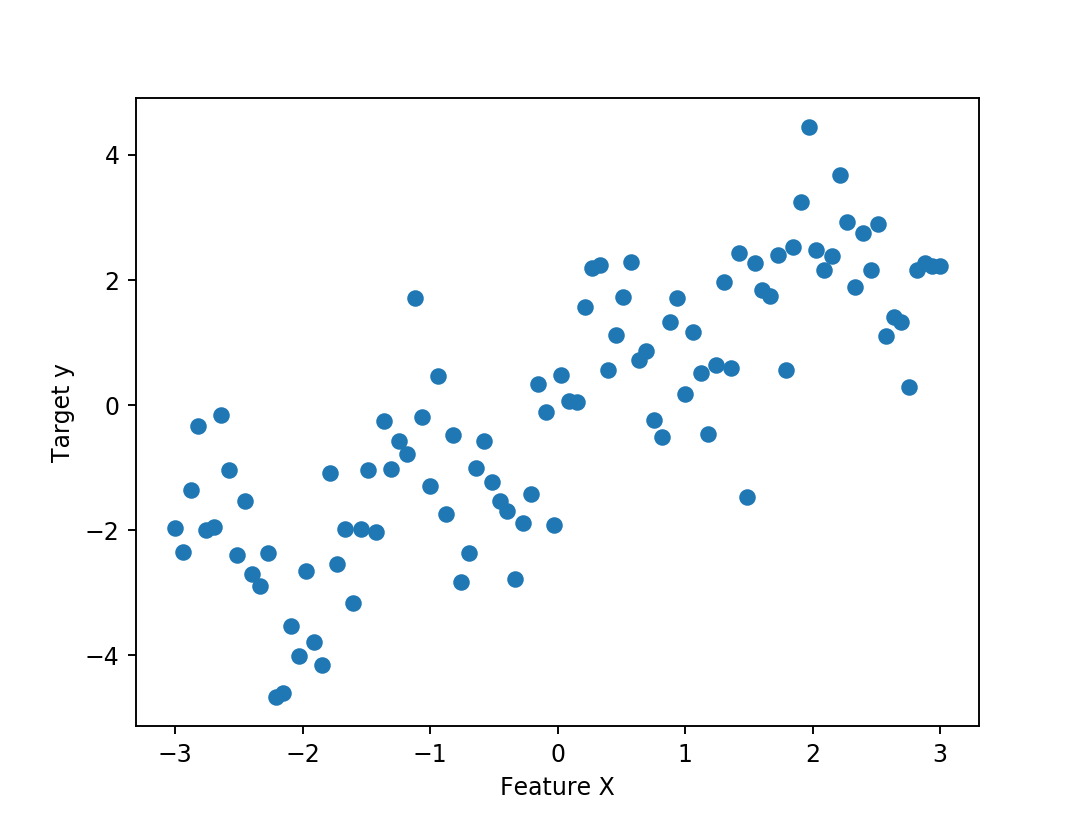

In [2]:
from figures import make_dataset
x, y = make_dataset()
X = x.reshape(-1, 1)

plt.figure()
plt.xlabel('Feature X')
plt.ylabel('Target y')
plt.scatter(X, y);

<IPython.core.display.Javascript object>


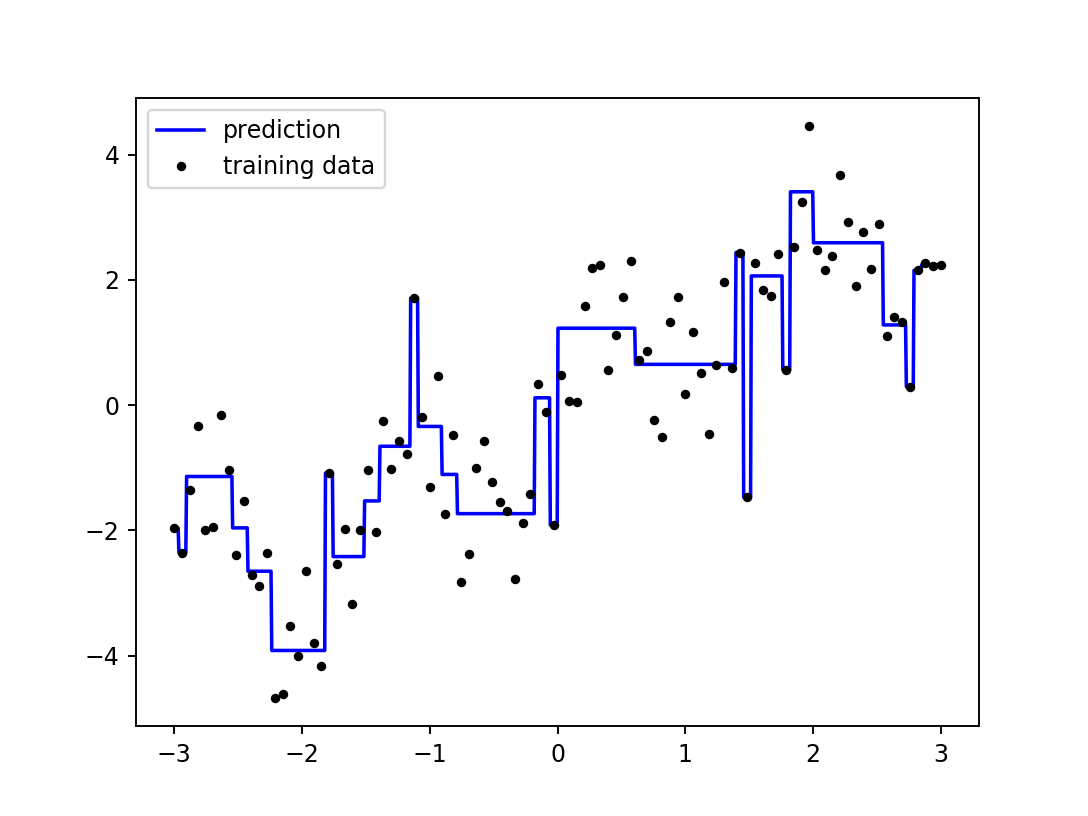

In [3]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(max_depth=5)
reg.fit(X, y)

X_fit = np.linspace(-3, 3, 1000).reshape((-1, 1))
y_fit_1 = reg.predict(X_fit)

plt.figure()
plt.plot(X_fit.ravel(), y_fit_1, color='blue', label="prediction")
plt.plot(X.ravel(), y, '.k', label="training data")
plt.legend(loc="best");

A single decision tree allows us to estimate the signal in a non-parametric way,
but clearly has some issues.  In some regions, the model shows high bias and
under-fits the data.
(seen in the long flat lines which don't follow the contours of the data),
while in other regions the model shows high variance and over-fits the data
(reflected in the narrow spikes which are influenced by noise in single points).

Decision Tree Classification
==================
Decision tree classification work very similarly, by assigning all points within a leaf the majority class in that leaf:


<IPython.core.display.Javascript object>


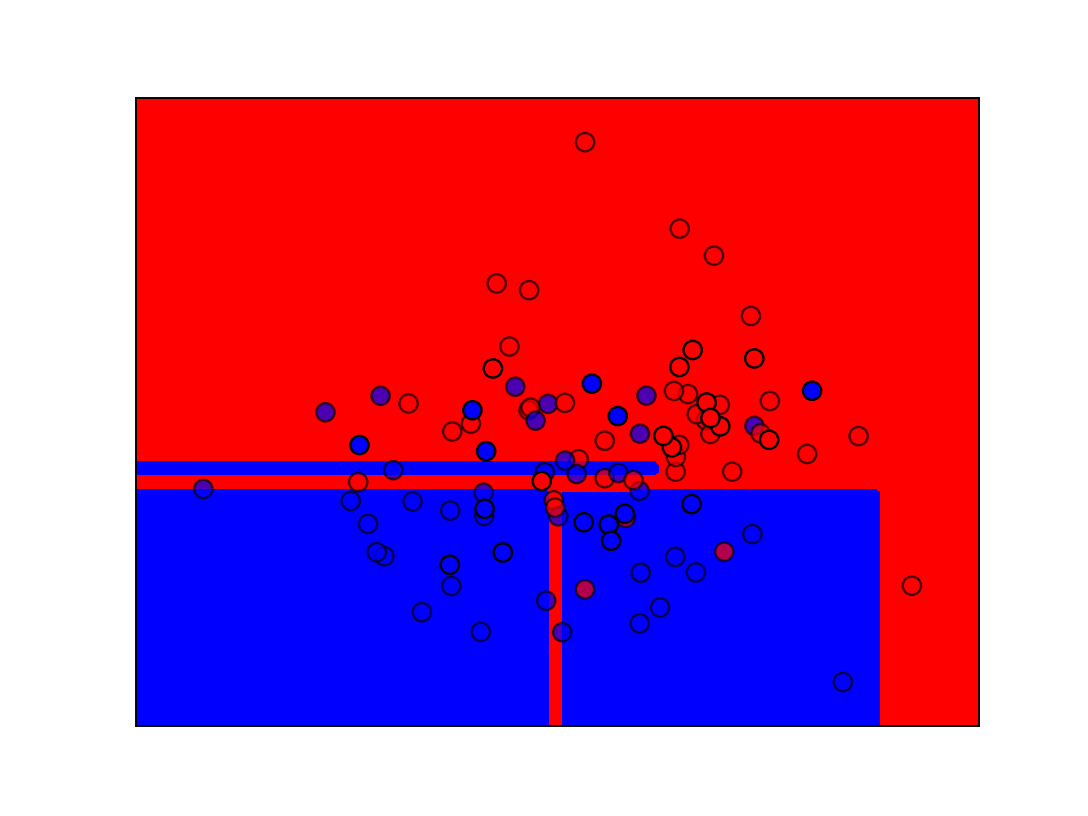

In [4]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from figures import plot_2d_separator


X, y = make_blobs(centers=[[0, 0], [1, 1]], random_state=61526, n_samples=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)

plt.figure()
plot_2d_separator(clf, X, fill=True)
plt.scatter(X_train[:, 0], X_train[:, 1], c=np.array(['b', 'r'])[y_train], s=60, alpha=.7, edgecolor='k')
plt.scatter(X_test[:, 0], X_test[:, 1], c=np.array(['b', 'r'])[y_test], s=60, edgecolor='k');

There are many parameter that control the complexity of a tree, but the one that might be easiest to understand is the maximum depth. This limits how finely the tree can partition the input space, or how many "if-else" questions can be asked before deciding which class a sample lies in.

This parameter is important to tune for trees and tree-based models. The interactive plot below shows how underfit and overfit looks like for this model. Having a ``max_depth`` of 1 is clearly an underfit model, while a depth of 7 or 8 clearly overfits. The maximum depth a tree can be grown at for this dataset is 8, at which point each leave only contains samples from a single class. This is known as all leaves being "pure."

In the interactive plot below, the regions are assigned blue and red colors to indicate the predicted class for that region. The shade of the color indicates the predicted probability for that class (darker = higher probability), while yellow regions indicate an equal predicted probability for either class.

In [5]:
# %matplotlib inline
from figures import plot_tree_interactive
plot_tree_interactive()

Decision trees are fast to train, easy to understand, and often lead to interpretable models. However, single trees often tend to overfit the training data. Playing with the slider above you might notice that the model starts to overfit even before it has a good separation between the classes.

Therefore, in practice it is more common to combine multiple trees to produce models that generalize better. The most common methods for combining trees are random forests and gradient boosted trees.


## Random Forests

Random forests are simply many trees, built on different random subsets (drawn with replacement) of the data, and using different random subsets (drawn without replacement) of the features for each split.
This makes the trees different from each other, and makes them overfit to different aspects. Then, their predictions are averaged, leading to a smoother estimate that overfits less.


In [6]:
from figures import plot_forest_interactive
plot_forest_interactive()

## Selecting the Optimal Estimator via Cross-Validation

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

digits = load_digits()
X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf = RandomForestClassifier(n_estimators=200)
parameters = {'max_features':['sqrt', 'log2', 10],
              'max_depth':[5, 7, 9]}

clf_grid = GridSearchCV(rf, parameters, n_jobs=-1)
clf_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': ['sqrt', 'log2', 10], 'max_depth': [5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [8]:
clf_grid.score(X_train, y_train)

1.0

In [9]:
clf_grid.score(X_test, y_test)

0.97777777777777775

## Another option: Gradient Boosting

Another Ensemble method that can be useful is *Boosting*: here, rather than
looking at 200 (say) parallel estimators, We construct a chain of 200 estimators
which iteratively refine the results of the previous estimator.
The idea is that by sequentially applying very fast, simple models, we can get a
total model error which is better than any of the individual pieces.

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=.2)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.997552055477
0.858078026707


<div class="alert alert-success">
    <b>EXERCISE: Cross-validating Gradient Boosting</b>:
     <ul>
      <li>
      Use a grid search to optimize the `learning_rate` and `max_depth` for a Gradient Boosted
Decision tree on the digits data set.
      </li>
    </ul>
</div>

In [11]:
from sklearn.datasets import load_digits
from sklearn.ensemble import GradientBoostingClassifier

digits = load_digits()
X_digits, y_digits = digits.data, digits.target

# split the dataset, apply grid-search

In [12]:
#%load solutions/18_gbc_grid.py

## Feature importance

Both RandomForest and GradientBoosting objects expose a `feature_importances_` attribute when fitted. This attribute is one of the most powerful feature of these models. They basically quantify how much each feature contributes to gain in performance in the nodes of the different trees.

In [13]:
X, y = X_digits[y_digits < 2], y_digits[y_digits < 2]

rf = RandomForestClassifier(n_estimators=300, n_jobs=1)
rf.fit(X, y)
print(rf.feature_importances_)  # one value per feature

[  0.00000000e+00   3.52543766e-05   8.94762529e-04   5.27742279e-03
   1.45437049e-03   4.55306949e-03   3.52318985e-03   0.00000000e+00
   0.00000000e+00   1.35747525e-04   2.43882827e-02   9.10725237e-04
   1.22723074e-03   5.83292140e-03   3.65754593e-04   0.00000000e+00
   1.86312259e-05   8.84706728e-03   7.62433856e-03   2.58973922e-02
   6.00488497e-02   1.20610005e-03   1.30166591e-02   0.00000000e+00
   1.18732085e-04   6.30483011e-03   8.79871967e-04   6.16731103e-02
   1.49555973e-01   2.65472884e-03   9.99541650e-02   0.00000000e+00
   0.00000000e+00   2.76581170e-02   7.69461856e-03   4.31254893e-02
   1.51945882e-01   4.39923738e-03   7.77297835e-02   0.00000000e+00
   0.00000000e+00   1.36826058e-02   2.43435386e-02   1.04942348e-02
   6.36650170e-02   3.07221778e-03   3.25740804e-02   0.00000000e+00
   0.00000000e+00   2.27284535e-04   3.00381063e-02   2.83980111e-03
   6.79740309e-04   2.28040156e-03   3.89319794e-04   2.32459329e-03
   0.00000000e+00   1.85649308e-05

In [14]:
plt.imshow(rf.feature_importances_.reshape(8, 8), cmap=plt.cm.viridis, interpolation='nearest')